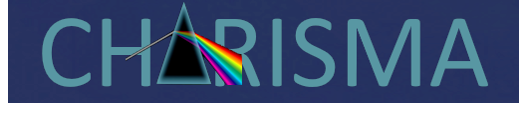

# CHARISMA Deliverable 4.2 Demonstration
#### *Bastian Barton, Fraunhofer LBF* - Sept. 15, 2021
Functionality of the Python software package *RamanChada* is demonstrated as hosted on GitHub:

https://gitlab.cc-asp.fraunhofer.de/barton/charisma-raman-spectrum-harmonization

***

### This Deliverable follows up to Work Package 4 Tasks 4.2 and 4.3

**Task T4.2: Data import, background and cosmic ray correction, and noise reduction**

- Data import routines will be built for all relevant native manufacturer formats.

- Optimised algorithms for background and cosmic ray correction as well as noise reduction will be developed and implemented in Python.

- Different numerical algorithms published in literature will be implemented and cross-validated using data from reference master samples specified by WP3. 

**Task 4.3. Spectrometer shift, gain, and modulation transfer function correction**

- Algorithms for correction of wavenumber-dependent spectrometer shift, gain, and MTF (peak broadening) will be developed, implemented in Python, and tested.

***

**Deliverable D4.2: Programs for correction of spectrometer recording artefacts (LBF, Month 10)**

*Python algorithms for:*

1. CHADA generation by native data import and conversion of spectra to the data structure defined in Task 4.1

1. correction of cosmic rays and noise reduction with minimal information loss

1. correction of shift, gain, and MTF based on measurements on standard samples.

1. Validation tests on >10 individual data sets generated in Task 3.4.

***

Import of required *Python* libraries

In [ ]:
from ramanchada.classes import RamanChada, make_test_RamanChada

In [ ]:
import os

In [ ]:
import warnings
warnings.filterwarnings('ignore')

***

## 1. Demonstration of CHADA generation by native data import

### File format CSV - Various manufacturers

#### Copper sulphate powder.CSV - ELODIZ - DXR Thermo

Load native file format and plot *RamanChada* spectrum

In [ ]:
path = r"ramanchada\src\ramanchada\testdata"
sample = "\Copper sulphate powder.CSV"

In [ ]:
R = RamanChada(path+sample)
R.plot()

Inspect *RamanChada* object

In [ ]:
R

Inspect metadata contained in *RamanChada* object

In [ ]:
R.meta

Check that *.cha* file has been created in directory

In [ ]:
path = os.path.dirname(path+sample)
[fn for fn in os.listdir(path) if fn.endswith('cha')]

Define display function to reduce code lines

In [ ]:
def show_import(filename):
    R = RamanChada(filename)
    R.plot()
    print(R)
    print('---METADATA---')
    print(list(R.meta.items())[:5])
    print('--- .CHA FILE---')
    path = os.path.dirname(filename)
    chafiles = [fn for fn in os.listdir(path) if fn.endswith('cha')]
    print(chafiles)

### File format JCAMP-DX - Various manufacturers

#### saffron.jdx

In [ ]:
sample = "\saffron.jdx"
show_import(path+sample)

### File format TXT - BWTek and various other manufacturers

#### AS020P frit.txt

In [ ]:
sample = "\AS020P frit.txt"
show_import(path+sample)

### File format SPC - GRAMS / Thermo Fisher, Galactic, Various manufacturers

#### Polystyrene.spc

In [ ]:
sample = "\Polystyrene.spc"
show_import(path+sample)

### File format SPA - Nicolet / Thermo (Omnic)

#### Titanium dioxide powder.SPA

In [ ]:
sample = "\Titanium dioxide powder.SPA"
show_import(path+sample)

### File format WDF - Renishaw Wire > 2.X

#### 200218-17.wdf

In [ ]:
sample = r"\200218-17.wdf"
show_import(path+sample)

### File format PRN - HORIBA

#### anthracen(csma).prn

In [ ]:
sample = r"\anthracen(csma).prn"
show_import(path+sample)

### File format  0, 1, ... - Bruker OPUS

#### Lactose.0 (this is IR data)

In [ ]:
sample = r"\Lactose.0"
show_import(path+sample)

***

## 2. Demonstration of correction of cosmic rays and noise reduction

### Correction of fluorescent background

Load test spectrum

In [ ]:
sample = r"\Lactose.0"
show_import(path+sample)

In [ ]:
B = make_test_RamanChada()
B.plot()

Fit baseline model using the SNIP algorithm and remove from data

In [ ]:
B.fit_baseline(method='snip')
B.remove_baseline()
B.plot()

Reset data. Fit baseline model using the ALS algorithm and remove from data

In [ ]:
B.rewind(0)
B.fit_baseline(method='als')
B.remove_baseline()
B.plot()

***

### Correction of cosmic rays

Load test spectrum

In [ ]:
sample = r"\72 polystyrene.spc"
X = RamanChada(path+sample)
X.plot()

Fit x ray model and plot

In [ ]:
X.fit_xrays()

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(X.y, label='raw data')
plt.plot(X.xrays, label='x ray model')
plt.legend()
plt.show()

Subtract x ray model and plot corrected spectrum

In [ ]:
X.remove_xrays()
X.plot()

***

### Noise reduction with minimal information loss

Load test spectrum

In [ ]:
sample = r"\27 polystyrene.spc"
N = RamanChada(path+sample)

Make *SpectrumGroup* to compare spectra

In [ ]:
from ramanchada.classes import SpectrumGroup

In [ ]:
G = SpectrumGroup([N])

Apply Savitzky-Golay smoothing filter

In [ ]:
N.smooth(method='sg')

Compare result to raw data

In [ ]:
G.add(N)

In [ ]:
G.process('x_crop', 1000, 1500)
G.plot()

***

## 3. Demonstration of correction of shift, gain, and MTF

### Correction of wavenumber shift - *x calibration*

Load test data (Neon spectra)

In [ ]:
neon_ref_file = r"\Neon_S120_x20_7000msx15.cha"
NEON_REF = RamanChada(path+neon_ref_file)

In [ ]:

neon_target_file = r"\Neon_Wasatch_Probe_2000msx15.csv"
NEON_TAR = RamanChada(path+neon_target_file)

Make *SpectrumGroup* to compare spectra

In [ ]:
N = SpectrumGroup([NEON_REF, NEON_TAR])
N.plot()

In [ ]:
N.process('x_crop', 0, 3200)
N.process('normalize')
N.plot()

Fit calibration by peak position comparison, using a Voigt distribution as peak model

In [ ]:
neon_cal = NEON_TAR.make_x_calibration(NEON_REF)

In [ ]:
neon_cal

Plot x calibration data (circles) and model (5th order polynomial, red).

- *RS correction*: Wavenumber-dependent x shift applied by the calibration.

Note that shifts outside the interval of mesured peaks are set to the boundary shifts rather than being interpolated.

In [ ]:
neon_cal.show()

The x calibration object has a timestamp.

In [ ]:
neon_cal.time

Calibrate the target spectrum using the generated calibration

In [ ]:
NEON_TAR.calibrate(neon_cal)

Group calibrated spectrum with original data to see result.

In [ ]:
N.add(NEON_TAR)
N.process('x_crop', 1700, 3000)
N.process('normalize', 'area')
N.plot()

- red - Reference spectrum

- blue - original Target spectrum

- purple - Target calibrated to Reference

***

### Correction of gain - *y calibration*

Generate y calibration using x-calibrated Target in the x Range 1,700 - 3,200 1/cm.

In [ ]:
neon_cal_y = NEON_TAR.make_y_calibration(NEON_REF, 1700, 3200)

In [ ]:
print(neon_cal_y)
print(neon_cal_y.y.mean())
print(neon_cal_y.y.std())

Calibrate the target spectrum using the generated calibration

In [ ]:
NEON_TAR.calibrate_y(neon_cal_y)

Group calibrated spectrum with original data to see result.

In [ ]:
N2 = SpectrumGroup([NEON_REF, NEON_TAR])

In [ ]:
N2.process('x_crop', 1700, 3000)
N2.process('normalize', 'minmax')
N2.plot()

- red - Reference spectrum

- blue - Target calibrated to Reference (x **and** y)

***

### Correction of MTF

*MTF*: modulation transfer function of digital detector

The MTF is the detector response to a single photon. This can be approximated by modelling a cosmic ray peak.

Load test spectrum that has x ray artifacts.

In [ ]:
file = r'/03 polystyrene.cha'
X = RamanChada(path+file)

In [ ]:
GX = SpectrumGroup([X])

X ray artifacts are automatically extracted from spectra in group GX, and used to generate an MTF model in Fourier space. This model is stored in a *RamanMTF* object (*cal_mtf*).

In [ ]:
cal_mtf = GX.make_mtf_calibration()

Inspect MTF calibration and plot in Fourier space

In [ ]:
cal_mtf

In [ ]:
cal_mtf.plot()

In [ ]:
X.fit_xrays()
X.remove_xrays()
GX.add(X)

In [ ]:
GX.plot()

- red - Original spectrum

- blue - x ray-corrected spectrum

Apply MTF calibration to spectrum

In [ ]:
X.deconvolve_MTF(cal_mtf)

In [ ]:
GX.add(X)
GX.process('x_crop', 900, 1100)
GX.process('normalize')
GX.plot()

- red/blue - original/x ray-corr. spectrum

- purple - MTF-corr. spectrum

Spectra recorded on the same detector can now be MTF-corrected using the calibration object / file.

In [ ]:
file = r'/27 polystyrene.cha'
X2 = RamanChada(path+file)

In [ ]:
GX2 = SpectrumGroup([X])

In [ ]:
X2.deconvolve_MTF(cal_mtf)

In [ ]:
GX2.add(X2)
GX2.process('x_crop', 900, 1600)
GX2.process('normalize')
GX2.plot()

- red - original spectrum

- blue - MTF-corr. spectrum

***

***

## 4. Validation tests on >10 individual data sets

**The following steps will be demonstrated for each test dataset:**

1. CHADA generation by native data import

1. correction of cosmic rays and noise reduction

1. correction of shift, gain, and MTF

Choose 10 independent datasets from various instruments and laboratories within the *CHARISMA* consortium

In [ ]:
files = [
    r"\saffron.jdx",
    r"\Copper sulphate powder.CSV",
    r"\AS020P frit.txt",
    r"\Polystyrene.spc",
    r"\200218-17.wdf",
    r"\anthracen(csma).prn",
    r"\SILICON_x20_1%_02.spc",
    r'\72 polystyrene.cha',
    r"\Neon_S120_x20_7000msx15.cha",
    r"\Anatase__R070582__Raman__532__0__unoriented__Raman_Data_RAW__23054.cha"
    ]

In [ ]:
len(files)

For each of the 10 datasets, the numerical methods are applied as described above. The original data is plotted with the processed data for comparison.

In [ ]:
for file in files:
    
    # Native data import and RamanChada generation
    R = RamanChada(path+file)
    
    # y data normalization
    R.normalize(x_min=250, x_max=3200)
    
    VAL = SpectrumGroup([R])
    VAL.data_labels[-1] = VAL.data_labels[-1] + ': original'
    
    # crop x to are of interest
    R.x_crop(100, 5000)
    
    # Baseline correction
    R.fit_baseline()
    R.remove_baseline()
    
    # x ray correction
    R.fit_xrays()
    R.remove_xrays()
    
    # Denoising
    R.smooth()
    
    # x calibration
    R.calibrate(neon_cal)
    
    # y (gain) calibration
    R.calibrate_y(neon_cal_y)
    
    # MTF correction
    R.deconvolve_MTF(cal_mtf)
    
    # y data normalization of processed spectrum
    R.normalize(x_min=250, x_max=3200)
    
    VAL.add(R)
    VAL.data_labels[-1] = VAL.data_labels[-1] + ': processed'
    VAL.plot()